In [10]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
import xml.etree.ElementTree
from collections import Counter, defaultdict
import pandas as pd
from scipy import stats
import random
from sklearn import metrics

In [11]:
def computePhraseFrequency(plists, window): 
            
    MAX=float("+inf")
    MIN=float("-inf")
        
    results=[]
    for l in plists:
        if len(l) < 1:
            return results
    
    positions=plists 
    index = [0] * len(positions)
    curr_occ = [0] * len (positions)
    max_curr_occ = MIN
    
    for i in range(0, len(positions)):
        curr_occ[i] = positions[i][0]
        if curr_occ[i] > max_curr_occ:
            max_curr_occ = curr_occ[i]
    
    lsym=0
    rsym=0
    lpos=0
    while max_curr_occ < MAX:
        _max = MIN
        _min = MAX
        for i in range(0, len(positions)):
            if curr_occ[i] > _max:
                _max = curr_occ[i]
                rsym = i
            if curr_occ[i] < _min:
                _min = curr_occ[i]
                lsym = i
                
        if index[lsym] == len(positions[lsym]) - 1 :
            lpos = MAX
        else :
            index[lsym]+=1
            lpos = positions[lsym][index[lsym]]
        
        if lpos > curr_occ[rsym] and curr_occ[rsym] - curr_occ[lsym] < window:
                results.append(curr_occ[lsym])
                
        max_curr_occ = MAX
        if lpos != MAX :
            max_curr_occ = MIN
            curr_occ[lsym] = lpos
            for i in range(0, len(positions)):
                if curr_occ[i] > max_curr_occ:
                    max_curr_occ = curr_occ[i]
    
    return results

## 0. Load Data

In [12]:
# qid docid docno doclen rel positions
def loadData():
    qid2reldoc = defaultdict(list)
    qid2irrdoc = defaultdict(list)
    docid2doclen = defaultdict(int)
    docid2flatlist = defaultdict(list)
    docid2proxlist = defaultdict(list)

    
    i = 0 
    with open("wtall_qrels_pos.clean.txt") as f:
        for l in f:
            # split row
            fields = l.split("\t")
            
            # get the data
            qid = int(fields[0])
            docid = int(fields[1])
            doclen=int(fields[3])
            rel=int(fields[4])
            plists = ast.literal_eval(fields[5])
            if len(plists)==1:
                prox_list=plists[0]
            else:
                prox_list = computePhraseFrequency(plists, 20)
            flat_list = [item for sublist in plists for item in sublist]

            
            # put data in dicts
            docid2doclen[docid] = doclen
            docid2flatlist[qid, docid] = flat_list
            docid2proxlist[qid, docid] = prox_list
            if rel > 0:
                qid2reldoc[qid].append(docid)
            else:
                qid2irrdoc[qid].append(docid)

    return  qid2reldoc, qid2irrdoc, docid2doclen, docid2flatlist, docid2proxlist

In [13]:
qid2reldoc, qid2irrdoc, docid2doclen, docid2flatlist, docid2proxlist = loadData()

In [14]:
print len(qid2reldoc)
rel = set(qid2reldoc.keys())
#print rel

print len(qid2irrdoc)
irel = set(qid2irrdoc.keys())
#print irel

print "Queries without relevant results!!!", irel.difference(rel)

194
198
Queries without relevant results!!! set([112, 152, 20, 143])


## 1.Load QueryID info

In [15]:
def loadQidInfo():
    qidDict = dict()
    for filename in os.listdir(os.curdir):
        if filename.endswith(".xml"):
            e = xml.etree.ElementTree.parse(filename).getroot()
            for query in e.findall('topic'):
                qidDict[int(query.get("number"))] = tuple([int(query.get("number")), query.get("type"), query[0].text])
    return qidDict

In [16]:
qidInfo = loadQidInfo()
print len(qidInfo)
allQ = set(qidInfo.keys())

%store qidInfo

# print "Queries non processed by Terrier", allQ.difference(irel)

200
Stored 'qidInfo' (dict)


In [17]:
for i in [188,87,193,177,7,66]:
    print qidInfo[i]
    
print qidInfo[106]

(188, 'faceted', 'internet phone service')
(87, 'faceted', 'who invented music')
(193, 'faceted', 'dog clean up bags')
(177, 'faceted', 'best long term care insurance')
(7, 'faceted', 'air travel information')
(66, 'ambiguous', 'income tax return online')
(106, 'faceted', 'universal animal cuts reviews')


## 2. Build OCCURENCE Probability MATRIX

In [18]:
def buildProbability(flatlists, max_doc_len=2000):
    probability = np.zeros(max_doc_len)
    occurence_ndarray = np.zeros(max_doc_len)
    for fl in flatlists:
        filtered_flatlist = [x for x in fl if x < max_doc_len]
        occurence_ndarray[filtered_flatlist] += 1
    if len(flatlists) > 0:
        probability = occurence_ndarray / occurence_ndarray.sum()
    if True in np.isnan(probability):
        probability = np.zeros(2000)
    return probability

In [19]:
qid_RelevantDocsDistribFlat = dict()
qid_AllDocsDistribFlat = dict() 
qid_RelevantDocsDistribProx = dict()
qid_AllDocsDistribProx = dict() 

In [20]:
# at PER QUERY level

#### RELEVANT
for qid, relDocidList in qid2reldoc.iteritems():
    if qid == 102: 
        print qid, qidInfo[qid], relDocidList, docid2flatlist[qid, docid]
    flatlists = [docid2flatlist[qid, docid] for docid in relDocidList]
    p = buildProbability(flatlists)
    qid_RelevantDocsDistribFlat[qid] = p
    proxlists = [docid2proxlist[qid, docid] for docid in relDocidList]
    p = buildProbability(proxlists)
    qid_RelevantDocsDistribProx[qid] = p

/home/muntean/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


102 (102, 'faceted', 'fickle creek farm') [13286514] []


In [ ]:
#### ALL for that query
allflatlists={}
allproxlists={}
for qid, docid in docid2flatlist:
    if qid not in allflatlists:
        allflatlists[qid]=[]
    allflatlists[qid].append(docid2flatlist[qid, docid])
for qid, docid in docid2proxlist:
    if qid not in allproxlists:
        allproxlists[qid]=[]
    allproxlists[qid].append(docid2proxlist[qid, docid])    
    
for qid in allflatlists:
    p = buildProbability(allflatlists[qid])
    qid_AllDocsDistribFlat[qid] = p
        
for qid in allproxlists:
    p = buildProbability(allproxlists[qid])
    qid_AllDocsDistribProx[qid] = p

In [21]:
def bucketandreshape(x, bucket_size):
    return x.reshape(x.size // bucket_size, bucket_size).sum(axis=1)

In [13]:
print len(qid_RelevantDocsDistribFlat)

194


## 3. Clustering

### FOR RELEVANT!!!

In [22]:
# ordering ids and corresponding probab distrib
bucket_size = 100 # this means we have 20 buckets!

all_probab = []
all_qids = []
for qid in range(201):
    if qid in qid_RelevantDocsDistribFlat:
        all_qids.append(qid)
#         all_probab_ndarray = np.vstack([all_probab_ndarray, qid_RelevantDocsDistribFlat[qid]])
        aux = bucketandreshape(qid_RelevantDocsDistribFlat[qid], bucket_size)
        all_probab.append(aux) 

all_probab_ndarray = np.array(all_probab)
    
# print len(all_probab_ndarray)
print len(all_qids), all_qids

194 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200]


### 3.1 K-means

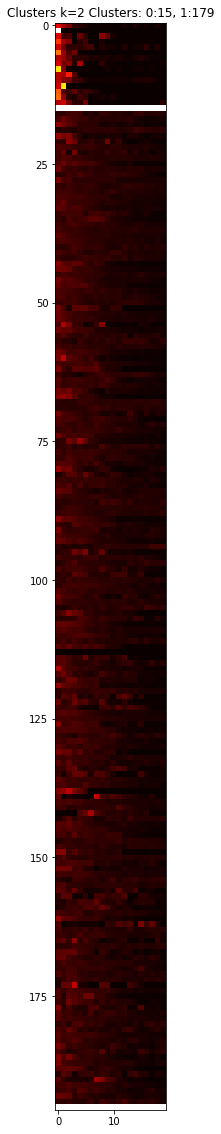

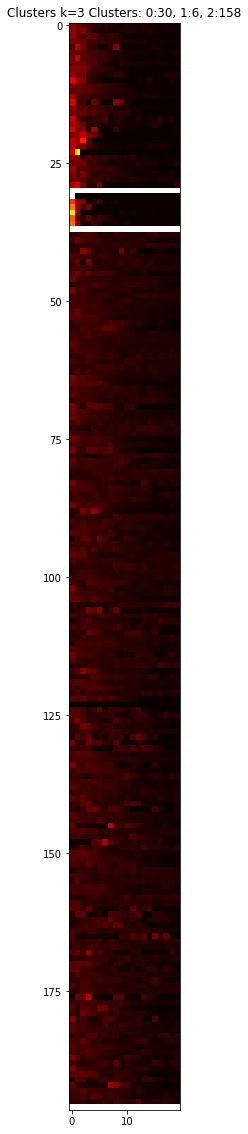

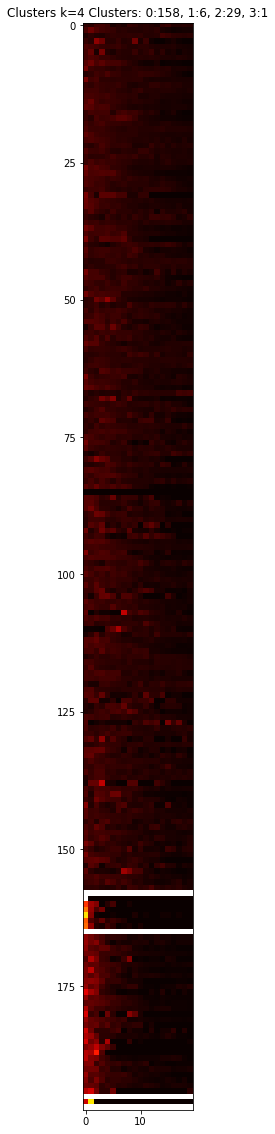

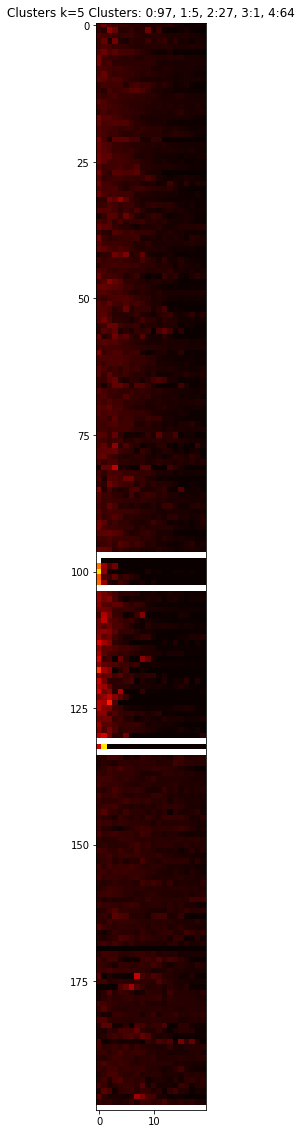

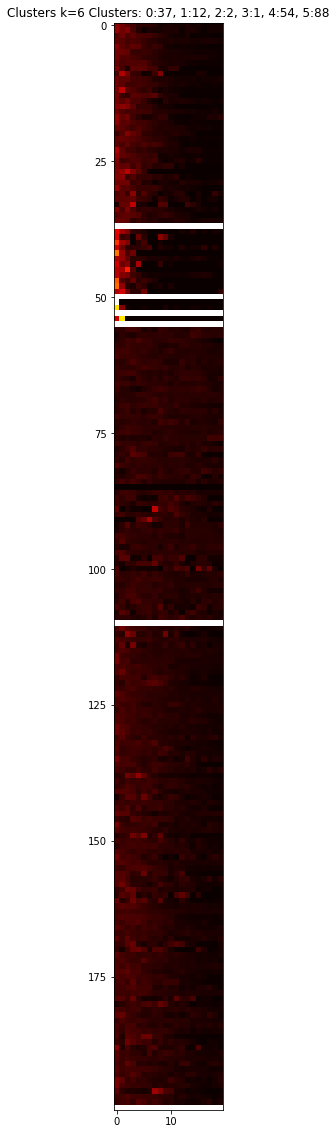

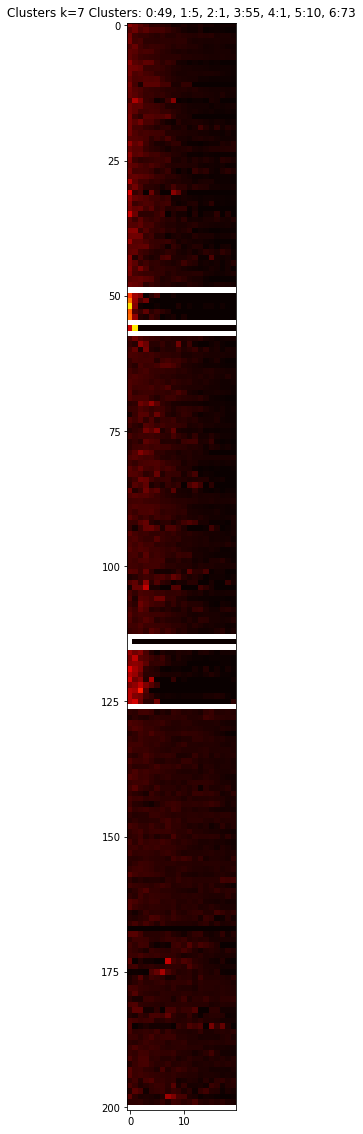

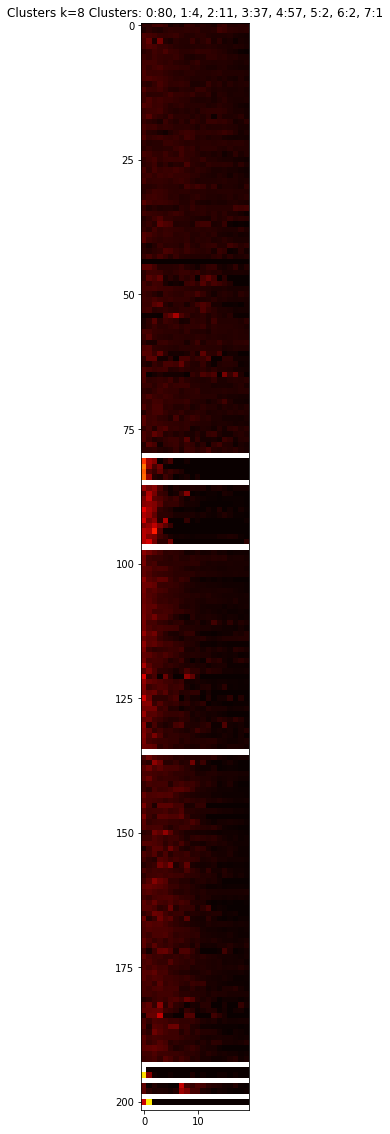

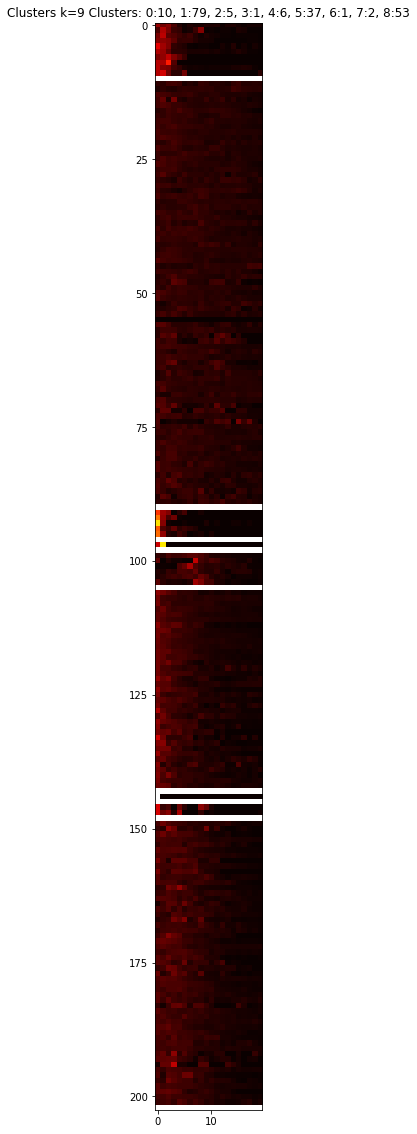

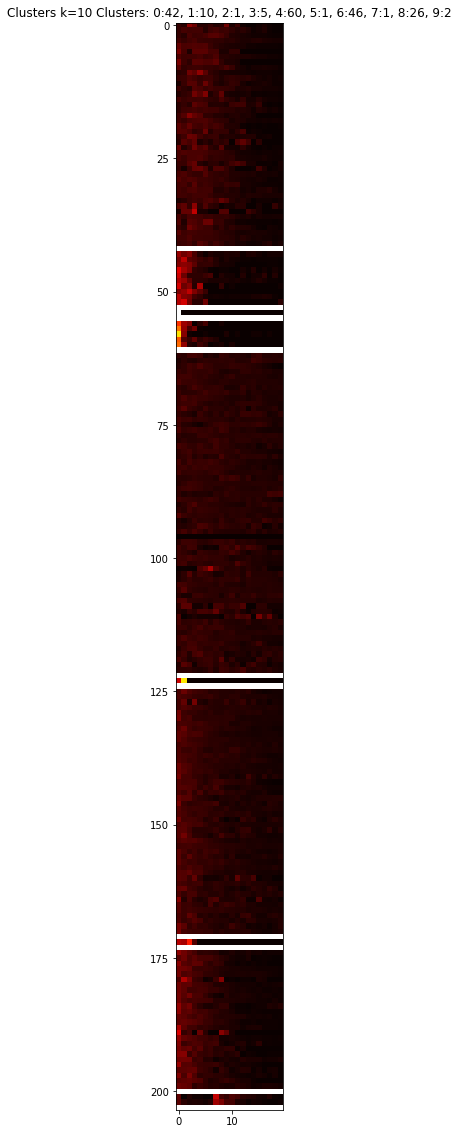

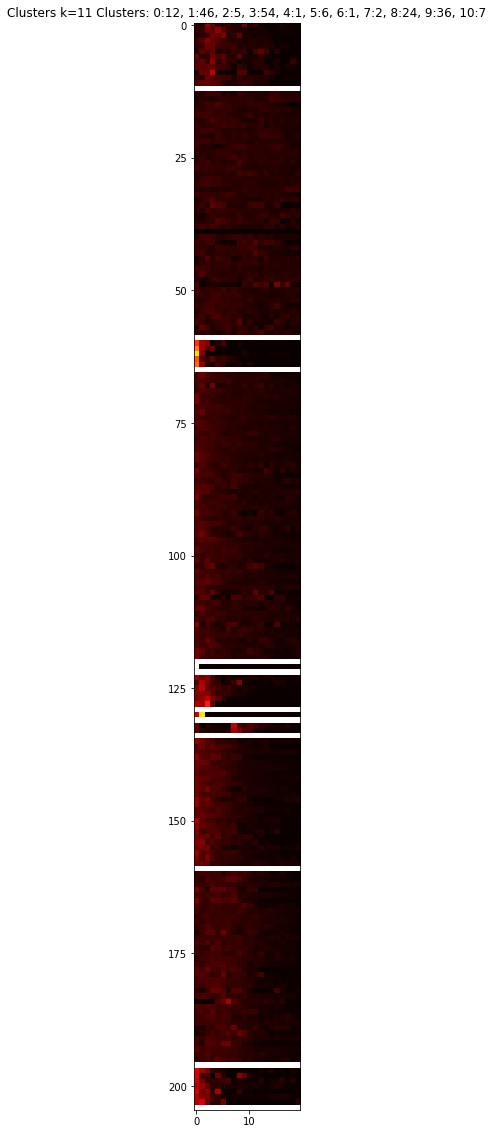

In [29]:
from sklearn.cluster import KMeans

resultDictList = []
for i in range(2,12):
#     print "------------------------------------------------------------------"
#     print "Clusters: ", i
    kmeans = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(all_probab_ndarray)
#     print len(kmeans.labels_), kmeans.labels_
#     print kmeans
    

    resultDict = defaultdict(list)
    for p,v in enumerate(kmeans.labels_):
        qid = all_qids[p]
        resultDict[v].append(qid)
    
    resultDictList.append(resultDict)
    
    plt.figure(figsize=(100, 20))
    
    cluster_list = []
    for cluster, queries in resultDict.iteritems():
#         plt.figure(figsize=(100, 20))
#         cluster_list = []
#         print "Cluster Number: ", cluster, len(queries)
#         print ", ".join([str(qidInfo[q]) for q in queries])
        for x in queries:
            index_qid = all_qids.index(x)
            cluster_list.append(all_probab_ndarray[index_qid, :])
        cluster_list.append(np.ones(20))
    plt.imshow(cluster_list, cmap="hot")
    title_str= ', '.join(['%s:%s' % (key, len(value)) for (key, value) in resultDict.items()])
    plt.title("Clusters k=" + str(i)+ " Clusters: " + title_str)
    

In [30]:
%store resultDictList

Stored 'resultDictList' (list)


# Split WTall queries and qrels into files corresponding to clusters

In [16]:
## Visualize
for cluster, queries in resultDict.iteritems():
    print "Cluster Number: ", cluster, len(queries), queries
    print ", ".join([str(qidInfo[q]) for q in queries])

print resultDict

%store resultDict

Cluster Number:  0 12 [6, 61, 82, 93, 108, 113, 114, 168, 170, 176, 179, 193]
(6, 'ambiguous', 'kcs'), (61, 'ambiguous', 'worm'), (82, 'ambiguous', 'joints'), (93, 'ambiguous', 'raffles'), (108, 'faceted', 'ralph owen brewster'), (113, 'faceted', 'hp mini 2140'), (114, 'faceted', 'adobe indian houses'), (168, 'faceted', 'lipoma'), (170, 'ambiguous', 'scooters'), (176, 'ambiguous', 'weather strip'), (179, 'faceted', 'black history'), (193, 'faceted', 'dog clean up bags')
Cluster Number:  1 46 [1, 4, 12, 14, 15, 26, 28, 36, 43, 44, 49, 54, 55, 62, 71, 72, 73, 75, 81, 83, 84, 86, 87, 92, 94, 99, 102, 111, 115, 120, 139, 142, 148, 149, 153, 157, 165, 166, 167, 169, 173, 175, 183, 188, 194, 200]
(1, 'faceted', 'obama family tree'), (4, 'faceted', 'toilet'), (12, 'faceted', 'djs'), (14, 'faceted', 'dinosaurs'), (15, 'ambiguous', 'espn sports'), (26, 'faceted', 'lower heart rate'), (28, 'ambiguous', 'inuyasha'), (36, 'faceted', 'gps'), (43, 'faceted', 'the secret garden'), (44, 'ambiguous', '

In [31]:
### Print a BIG cat command

for cluster, queries in resultDict.iteritems():
    stringa = "cat "
    for query in queries:
        stringa += "all-matches-fields-tfs-qid-" + str(query) + "-filtered.txt "
    stringa += "> all-matches-fields-tfs-cluster-" + str(cluster) + ".txt"
    print 
    print 
    print "# Cluster ", cluster
    print stringa

stringb = "cat "
for query in allQ.difference(rel):    
    stringb += "all-matches-fields-tfs-qid-" + str(query) + "-filtered.txt "
stringb += "> all-matches-fields-tfs-cluster-11.txt"
print 
print 
print "# Cluster 11"
print stringb




# Cluster  0
cat all-matches-fields-tfs-qid-6-filtered.txt all-matches-fields-tfs-qid-61-filtered.txt all-matches-fields-tfs-qid-82-filtered.txt all-matches-fields-tfs-qid-93-filtered.txt all-matches-fields-tfs-qid-108-filtered.txt all-matches-fields-tfs-qid-113-filtered.txt all-matches-fields-tfs-qid-114-filtered.txt all-matches-fields-tfs-qid-168-filtered.txt all-matches-fields-tfs-qid-170-filtered.txt all-matches-fields-tfs-qid-176-filtered.txt all-matches-fields-tfs-qid-179-filtered.txt all-matches-fields-tfs-qid-193-filtered.txt > all-matches-fields-tfs-cluster-0.txt


# Cluster  1
cat all-matches-fields-tfs-qid-1-filtered.txt all-matches-fields-tfs-qid-4-filtered.txt all-matches-fields-tfs-qid-12-filtered.txt all-matches-fields-tfs-qid-14-filtered.txt all-matches-fields-tfs-qid-15-filtered.txt all-matches-fields-tfs-qid-26-filtered.txt all-matches-fields-tfs-qid-28-filtered.txt all-matches-fields-tfs-qid-36-filtered.txt all-matches-fields-tfs-qid-43-filtered.txt all-matches-fie

In [47]:
### Print each cluster in separate file

# change dir
os.chdir("/home/muntean//cw09b_urls_blocks_nostem/eval")

# iter clusters and write to file
for cluster, queries in resultDict.iteritems():
    with open("wt-cluster-" + str(cluster)+".txt", "w") as f:
        for query in queries:
            line = str(query) + ":" + qidInfo[query][2] + "\n"
            f.write(line)
        f.close()

In [57]:
# write another file with queries without relevant results or unprocessed
# cluster 11
with open("wt-cluster-11.txt", "w") as f:
    for query in allQ.difference(rel):
        print query
        line = str(query) + ":" + qidInfo[query][2] + "\n"
        f.write(line)
    f.close()

100
143
112
20
152
95


In [67]:
# Split eval file into clusters
for cluster, queries in resultDict.iteritems():
    with open("wt-cluster-" + str(cluster)+".qrels", "w") as outputFile:
        with open("wtall.qrels", "r") as inputFile:
            for line in inputFile:
                queryId = int(line.split()[0])
                if queryId in queries:
                    outputFile.write(line)

In [4]:
# Split eval file into query.qrels

# change dir
os.chdir("/home/muntean//cw09b_urls_blocks_nostem/eval")
for query in range(1,201):
    with open("wt-query-" + str(query)+".qrels", "w") as outputFile:
        with open("wtall.qrels", "r") as inputFile:
            for line in inputFile:
                queryId = int(line.split()[0])
                if queryId==query:
                    outputFile.write(line)

In [66]:
queriesNot = list(allQ.difference(rel))
print queriesNot
with open("wt-cluster-11.qrels", "w") as outputFile:
    with open("wtall.qrels", "r") as inputFile:
        for line in inputFile:
            queryId = int(line.split()[0])
            if queryId in queriesNot:
                print queryId
                outputFile.write(line)

[100, 143, 112, 20, 152, 95]
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
112
11

### 4.2 Gaussian mixture models

In [ ]:
from sklearn import mixture
 
def fit_samples(samples):
    
    gmix = mixture.GaussianMixture(n_components=3, covariance_type='full')
    gmix.fit(samples)
    print gmix.means_
    colors = ['r' if i==0 else 'c' for i in gmix.predict(samples)]
    
    plt.figure(figsize=(16, 3))
    ax = plt.gca()
    ax.scatter(samples[:,0], samples[:,1], c=colors, alpha=0.8, )
    plt.show()
    

fit_samples(all_probab_ndarray)

### 4.3 Hierarchical

1
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 7 0 0 8 0 0 0 0 0
 0 0 0 0 0 0 1 0 2 0 2 0 0 0 0 1 2 0 8 2 4 0 1 0 6 0 0 0 0 2 0 0 0 5 0 0 0
 2 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2
 0 0 0 4 0 0 0 2 0]


NameError: name 'X' is not defined

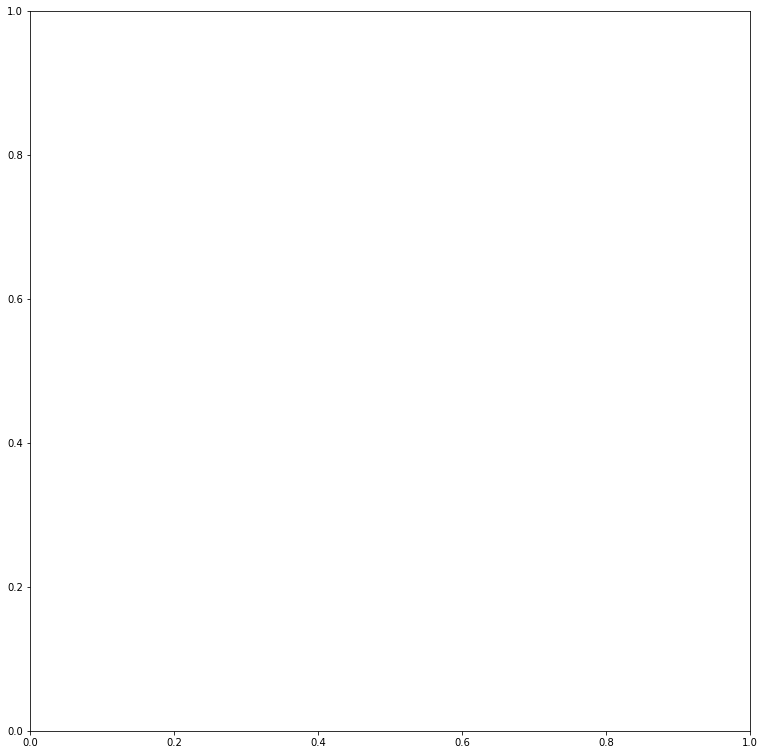

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

#http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering

for index, metric in enumerate(["euclidean", "l1"]):
    model = AgglomerativeClustering(n_clusters=10,
                                    linkage="complete", affinity=metric)
    model.fit(all_probab_ndarray)
    
    print model.n_components_
    print model.labels_

    
    plt.figure(figsize=(10,10))
    plt.axes([0, 0, 1, 1])
    for l, c in zip(np.arange(model.n_clusters), 'rgbk'):
        plt.plot(X[model.labels_ == l].T, c=c, alpha=.5)
    plt.axis('tight')
    plt.axis('off')
    plt.suptitle("AgglomerativeClustering(affinity=%s)" % metric, size=20)
